In [1]:
# load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from sklearn import linear_model
from datetime import datetime
from itertools import product
import statsmodels.api as sm
import warnings

%matplotlib inline

In [2]:
# подгружаем данные

# id нужных регионов
regsDf = pd.read_csv('../crowdRegs.csv',names=['id','regId']);  

# временные ряды для этих регионов
df = pd.read_pickle('../crowdRegs2.pcl')
df.columns = regsDf.regId.values.astype('str')

# словарь с группировкой рядов
tsGroups = np.load('tsGroups.npy').item()

In [3]:
startDate = '2016-01-01 0:0:0'
endDate = '2016-04-30 23:59:59'

__Идея__ в том, что обучение SARIMAX модели на сглаженных регрессионных данных даст лучший резульатат.
Как проверить: сравниваем качество предсказаний SARIMAX модели, обученной на разных регрессионных признакаха:
        1) регрессор обучается на данных без сглаживания
        2) регрессор обучается на данных, сглаженных Гауссовой функциец с шириной в 24 часа
        3) регрессор обучается на данных, сглаженных кубическим сплайном, сгенерированным на среднесуточных значениях
        4) ???
        
__*Что надо сделать:*__

<ol>
<li> Функция генерации регрессионной последовательности


<ul>
<li> среднее за день
<li> гауссово сглаживание
<li> кубическая интерполяция
</ul>


<li> Функция регрессора (может быть лучше использовать ElasticNet) с подбором оптимальных параметров. Подбор осуществлять на январе-марте, кросс-валидацию на апреле.

<li> Функция обучения SARIMAX модели с подбором оптимальных параметров и использованием регрессионных компонент. 


</ol>
    

In [51]:
startDate = '2016-01-01 0:0:0'
endDate = '2016-01-31 23:59:59'
ts = df.loc[startDate:endDate,'1274'].to_frame(name ='trips_count') # it works
gr = ts.groupby(ts.index.floor('1D')).mean()

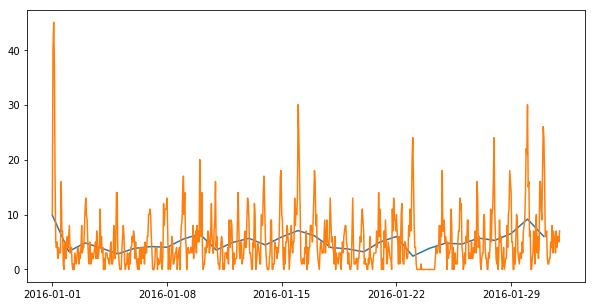

In [54]:
plt.figure(figsize=[10,5])
plt.plot(gr)
plt.plot(ts)

In [61]:
# add features
def addFeatures(res, Kw = 6, Ka = 3):
    """
    Добавляем фичи
    Params:
      Kw - количество недельных гармоник
      Ka - количество годовых гармоник
      alpha - параметр регрессора
    """
    
    # add linear feature
    res = res.assign(hours = (res.index-res.index[0])/np.timedelta64(1, 'h'))
    
    # добавляем гармонические фичи
    for ind in range(1,Kw+1):
        res['weekCos'+str(ind)]= np.cos(np.pi*res.hours*ind/168);
        res['weekSin'+str(ind)]= np.sin(np.pi*res.hours*ind/168);
    for ind in range(1,Ka+1):
        res['yearCos'+str(ind)]= np.cos(2*np.pi*res.hours*ind/8766);
        res['yearSin'+str(ind)]= np.sin(2*np.pi*res.hours*ind/8766);
        
    # добавляем dummy variables для дней недели
    DoW = pd.get_dummies(res.index.dayofweek,drop_first= True,prefix = 'dayofWeek')
    DoW.index = res.index
    res = res.merge(DoW,left_index=True,right_index=True)
    
    # добавляем dummy variables для месяца
    mth = pd.get_dummies(res.index.month,drop_first= True,prefix = 'month');
    mth.index = res.index;
    res = res.merge(mth,left_index=True,right_index=True);
    return res

# it works!!!

In [64]:
# regressor
def regressor(res,train=['2016-01-01 0:0:0','2016-03-31 23:59:59'],
              testStart=['2016-04-01 0:0:0','2016-04-30 23:59:59']):
    """
    Регрессионная функция с подбором гиперпараметров
    train - начало 
    """

Теперь надо подобрать параметры моделей. Для этого можно использовать какой-то один ряд, либо попробовоть усреднять ряды внутри групп и уже для усреднённых рядов подбирать параметры.

Для начала построим и визуально оценим усреднение. Возьмём первую группу.

In [4]:
gr = 'gr0'
for grName, grVal in tsGroups.items():
    grSeries = df.loc[:,grVal].apply(lambda x: (x - x.mean()), raw = True)
    #grSeries = grSeries.apply(lambda x: x /(x.std()), raw = True)
    
    #plt.plot()
    #grSeries.assign(ms = grSeries.mean(1)).plot(subplots = True,figsize = [15,10])
    #plt.title(grName)
    #plt.xlim(['2016-01-02','2016-01-31'])

In [5]:
# выберу настроечные ряды руками
fitSeries = {'gr18':'1274','gr19':'1684','gr10':'1333','gr11':'1075','gr12':'2118','gr13':'1387','gr14':'1384','gr15':'1174'}
fitSeries.update({'gr16':'1483','gr17':'1282','gr21':'1184','gr20':'1131','gr23':'1332','gr22':'1580','gr6':'1326','gr7':'1388'})
fitSeries.update({'gr4':'1129','gr2':'1234','gr3':'1231','gr0':'1286','gr1':'1125','gr8':'1181','gr9':'1532'})

In [6]:
def regression(res, Kw = 6, Ka = 3, alpha = 0.1):
    """
    Функция поиска оптимальной SARIMAX модели
    Return [predicted value, residual, LASSO regressor]
    
    Params:
      Kw - количество недельных гармоник
      Ka - количество годовых гармоник
      alpha - параметр регрессора
    """
    
    # add linear feature
    res = res.assign(hours = (res.index-res.index[0])/np.timedelta64(1, 'h'))
    
    # добавляем гармонические фичи
    for ind in range(1,Kw+1):
        res['weekCos'+str(ind)]= np.cos(np.pi*res.hours*ind/168);
        res['weekSin'+str(ind)]= np.sin(np.pi*res.hours*ind/168);
    for ind in range(1,Ka+1):
        res['yearCos'+str(ind)]= np.cos(2*np.pi*res.hours*ind/8766);
        res['yearSin'+str(ind)]= np.sin(2*np.pi*res.hours*ind/8766);
        
    # добавляем dummy variables для дней недели
    DoW = pd.get_dummies(res.index.dayofweek,drop_first= True,prefix = 'dayofWeek')
    DoW.index = res.index
    res = res.merge(DoW,left_index=True,right_index=True)
    
    # добавляем dummy variables для месяца
    mth = pd.get_dummies(res.index.month,drop_first= True,prefix = 'month');
    mth.index = res.index;
    res = res.merge(mth,left_index=True,right_index=True);
    
    X = res.drop('count',axis = 1);
    y = res.loc[:,'count'];
    lassoReg = linear_model.Lasso(alpha = alpha, max_iter = 1e5,fit_intercept = True,random_state = 0);
    lassoReg.fit(X,y)
    y_pr = pd.Series(data = lassoReg.predict(X), index = res.index)
    R = lassoReg.score(X,y);
    print 'R factor is ', R
    
    plt.figure(figsize = [15,10])
    plt.subplot(211)
    plt.plot(y)
    plt.plot(y_pr)
    plt.legend(['Original data','Predicted'])
    
    plt.subplot(212)
    plt.plot(y-y_pr)
    plt.legend(['Residuals'])
    return [y_pr, y-y_pr, lassoReg]

In [ ]:
testSeries = '1274'
[s, r, lasso] = regression(df.loc[startDate:endDate,testSeries].to_frame(name = 'count'),alpha = 0.01, Kw = 6, Ka = 3)

In [8]:
# Рядов много, модели обучаются долго, а ресурсов - мало. Поэтому будет подбирать параметры только для малых p и q.
ps = range(1, 5)
d=1
qs = range(1, 5)

Ps = range(1, 3)
D=1
Qs = range(1, 3)

parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

64

In [ ]:
# Обучаем модель

#%%time
warnings.filterwarnings('ignore')
paramsDict = {}

for grName, tsName in fitSeries.iteritems():
    
    print 'New groups'
    print grName, tsName

    results = []
    best_aic = float("inf")
    
    [s, r, lasso] = regression(df.loc[startDate:endDate,tsName].to_frame(name = 'count'),alpha = 0.01, Kw = 6, Ka = 3)
    # loop over parameters' list
    for param in parameters_list:
        #try except нужен, потому что на некоторых наборах параметров модель не обучается
        print('Parameters:', param)
        try:
            mSARIMA=sm.tsa.statespace.SARIMAX(df.loc[startDate:endDate,tsName].to_frame(), order=[param[0], 1, param[1]],
                                          seasonal_order=(param[2], 1, param[3], 24),exog = r,
                                             enforce_invertibility = True).fit(disp=1);
        #выводим параметры, на которых модель не обучается и переходим к следующему набору
        except Exception as inst:
            print type(inst)     # the exception instance
            print inst           # __str__ allows args to be printed directly
            continue
        aic = mSARIMA.aic
        print('AIC',aic) 
        #сохраняем лучшую модель, aic, параметры
        if aic < best_aic:
            best_model = mSARIMA
            best_aic = aic
            best_param = param
        results.append([param, mSARIMA.aic])
    print results
    paramsDict.update({grName: [aic, best_param]})
    print paramsDict
    
warnings.filterwarnings('default')

New groups
gr21 1184
R factor is  0.0238219675232
('Parameters:', (1, 1, 1, 1))
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
('Parameters:', (1, 1, 1, 2))
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
('Parameters:', (1, 1, 2, 1))
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
('Parameters:', (1, 1, 2, 2))
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
('Parameters:', (1, 2, 1, 1))
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
('Parameters:', (1, 2, 1, 2))
<type 'exceptions.ValueError'>
non-invertible starting MA parameters found with `enforce_invertibility` set to True.
('Parameters:', (1, 2, 2, 1))
<type 'exceptions.ValueError'>
non-inv